In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time, ast, os
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 50)
START_POI = 0
END_POI = 450
START_DATE = '2018-12-31'
TOTAL_DAYS = 400
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)
WINDOW_SIZE = 24
HORIZON = 6

In [3]:
class bounding_box:
    def __init__(self, _lat_min, _lon_min,_lat_max,_lon_max):
        self.lat_min = _lat_min
        self.lon_min = _lon_min
        self.lat_max = _lat_max
        self.lon_max = _lon_max


class stat_collector:
    def __init__(self):
        self.parquet_file_count=0
        self.data_record_count = 0
        self.memory_usage_in_GB = 0		#gives an estimate of the total RAM usage if all files were read into memory at the same time.
        self.unique_device_count = 0
        self.avg_pos_acc = 0
        self.starting_time = time.process_time()
        self.elapsed_time = time.process_time()
        self.unique_geohash_count = 0
        
def load_poi_db(HT_range=0.2, ht_lat=29.749907, ht_lon=-95.358421):
    HT_box = bounding_box(ht_lat - HT_range, ht_lon - HT_range, ht_lat + HT_range, ht_lon + HT_range)

    bbox = HT_box
    poi_folder = "/storage/dataset/poi_haowen/CoreRecords-CORE_POI-2019_03-2020-03-25/"
    poi_columns = ["safegraph_place_id", "parent_safegraph_place_id", "location_name", "safegraph_brand_ids", "brands",
                   "top_category", "sub_category", "naics_code", "latitude", "longitude", "street_address", "city",
                   "region", "postal_code", "iso_country_code", "phone_number", "open_hours", "category_tags"]
    files = os.listdir(poi_folder)


    poi_s = stat_collector()
    poi_db = pd.DataFrame(columns=poi_columns)
    for f in files:
        if f[-3:] == 'csv' and 'brand' not in f:
            print(f)
            df = pd.read_csv(poi_folder + f)
            df = df[
                (df['latitude'] > bbox.lat_min) & (df['latitude'] < bbox.lat_max) & (df['longitude'] > bbox.lon_min) & (
                            df['longitude'] < bbox.lon_max)]
            poi_db = poi_db.append(df, ignore_index=True, sort=False)
            poi_s.memory_usage_in_GB += df.memory_usage(deep=True).sum() / 1000000000
            poi_s.data_record_count += df.shape[0]
            poi_s.parquet_file_count += 1
    return poi_db, poi_s


def get_merged_df(csv_path, start_row, end_row):

    #start = time.time()
    merge_df = pd.read_csv(csv_path)

    merge_df = merge_df.sort_values(by=['raw_visit_counts'], ascending=False)
    merge_df = merge_df.iloc[start_row:end_row]
    #print(merge_df)
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: ast.literal_eval(x))
    merge_df["visits_by_each_hour"] = merge_df["visits_by_each_hour"].apply(lambda x: x[:TOTAL_DAYS*24])
    merge_df["visits_by_day"] = merge_df["visits_by_day"].apply(lambda x: x[:TOTAL_DAYS])
    return merge_df


In [4]:
def masked_MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    
    mask = (v < 1E-5)
    percentage = np.abs(v_ - v) / np.abs(v)
    percentage = np.where(percentage > 5, 5, percentage) # TODO remove this
    if np.any(mask):
        masked_array = np.ma.masked_array(percentage, mask=mask)  # mask the dividing-zero as invalid
        result = masked_array.mean(axis=axis)
        if isinstance(result, np.ma.MaskedArray):
            return result.filled(np.nan)
        else:
            return result
    return np.mean(percentage, axis).astype(np.float64)


def MAPE(v, v_, axis=None):
    '''
    Mean absolute percentage error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAPE averages on all elements of input.
    '''
    # TODO: Remove this line
    v_ = np.where(v_<0, 0,v_)
    mape = (np.abs(v_ - v) / np.abs(v)+1e-5).astype(np.float64)
    mape = np.where(mape > 5, 5, mape)
    return np.mean(mape, axis)


def RMSE(v, v_, axis=None):
    '''
    Mean squared error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, RMSE averages on all elements of input.
    '''
    return np.sqrt(np.mean((v_ - v) ** 2, axis)).astype(np.float64)




def MAE(v, v_, axis=None):
    '''
    Mean absolute error.
    :param v: np.ndarray or int, ground truth.
    :param v_: np.ndarray or int, prediction.
    :param axis: axis to do calculation.
    :return: int, MAE averages on all elements of input.
    '''

    return np.mean(np.abs(v_ - v), axis).astype(np.float64)


def evaluate(y, y_hat, by_step=False, by_node=False):
    '''
    :param y: array in shape of [count, time_step, node].
    :param y_hat: in same shape with y.
    :param by_step: evaluate by time_step dim.
    :param by_node: evaluate by node dim.
    :return: array of mape, mae and rmse.
    '''
    if not by_step and not by_node:
        return masked_MAPE(y, y_hat), MAE(y, y_hat), RMSE(y, y_hat)
    if by_step and by_node:
        return masked_MAPE(y, y_hat, axis=0), MAE(y, y_hat, axis=0), RMSE(y, y_hat, axis=0)
    if by_step:
        return masked_MAPE(y, y_hat, axis=(0, 2)), MAE(y, y_hat, axis=(0, 2)), RMSE(y, y_hat, axis=(0, 2))
    if by_node:
        return masked_MAPE(y, y_hat, axis=(0, 1)), MAE(y, y_hat, axis=(0, 1)), RMSE(y, y_hat, axis=(0, 1))

In [5]:
csv_path_weekly = '/home/users/arash/datasets/safegraph/weekly_patterns_2018-12-31_2020-06-08_Houston.csv'
csv_poi_info = '/home/users/arash/datasets/safegraph/core_poi_info_2018-12-31_2020-06-08.csv'
weekly_patterns = get_merged_df(csv_path_weekly, START_POI, END_POI)
poi_info = pd.read_csv(csv_poi_info)
poi_df = pd.merge(weekly_patterns, poi_info, on='safegraph_place_id', how='inner')
poi_df.head(3)

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall


In [6]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-10-08T00:00:00.000000000', '2019-10-08T01:00:00.000000000',
       '2019-10-08T02:00:00.000000000', ...,
       '2019-12-25T16:00:00.000000000', '2019-12-25T17:00:00.000000000',
       '2019-12-25T18:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
poi_db, poi_s = load_poi_db(HT_range=1.5)
poi_df = poi_df.merge(poi_db, how='left', on='safegraph_place_id', suffixes=('', '_y'))
poi_df.drop(poi_df.filter(regex='_y$').columns, axis=1, inplace=True)
del poi_db
poi_df.head(3)

core_poi-part2.csv
core_poi-part5.csv
core_poi-part4.csv
core_poi-part3.csv
core_poi-part1.csv


,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN


In [9]:
poi_df['visits_by_each_hour'] = poi_df['visits_by_each_hour'].apply(lambda x: np.array(x))
poi_df['visits_by_day'] = poi_df['visits_by_day'].apply(lambda x: np.array(x))
agg_df = poi_df.groupby('top_category').agg({'visits_by_day': 'sum',
                                    'visits_by_each_hour': 'sum',
                                    'raw_visit_counts': 'sum',
                                    'safegraph_place_id': 'count'})
agg_df.columns = ['daily_visits', 'hourly_visits', 'raw_visits', 'count']
agg_df.head()

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Amusement Parks and Arcades,"[167, 151, 145, 140, 178, 212, 114, 79, 90, 94...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 13, 15, 25, 18,...",56425,1
Automobile Dealers,"[423, 255, 425, 406, 465, 395, 195, 362, 426, ...","[0, 0, 0, 0, 1, 1, 7, 11, 14, 16, 24, 40, 35, ...",183807,3
Automotive Equipment Rental and Leasing,"[30, 0, 115, 146, 106, 11, 3, 162, 187, 213, 2...","[0, 0, 1, 0, 1, 3, 1, 5, 6, 1, 1, 1, 3, 5, 0, ...",52544,1
Book Stores and News Dealers,"[65, 11, 176, 202, 203, 27, 13, 186, 283, 241,...","[0, 1, 1, 0, 0, 3, 6, 11, 12, 4, 2, 4, 5, 5, 0...",165918,2
Building Material and Supplies Dealers,"[1324, 1024, 1211, 1352, 1606, 1657, 1437, 116...","[4, 3, 3, 3, 11, 12, 19, 36, 56, 85, 137, 146,...",1045663,18


In [10]:
agg_df.loc[agg_df['count'] == 2]

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Book Stores and News Dealers,"[65, 11, 176, 202, 203, 27, 13, 186, 283, 241,...","[0, 1, 1, 0, 0, 3, 6, 11, 12, 4, 2, 4, 5, 5, 0...",165918,2
Clothing Stores,"[270, 185, 344, 370, 433, 197, 157, 335, 367, ...","[1, 0, 0, 1, 0, 1, 5, 21, 10, 11, 16, 32, 23, ...",140180,2
Furniture Stores,"[491, 404, 360, 351, 445, 602, 617, 284, 219, ...","[0, 0, 1, 1, 1, 0, 3, 5, 6, 17, 47, 42, 49, 64...",196754,2
Home Health Care Services,"[268, 153, 269, 280, 342, 181, 185, 286, 291, ...","[3, 6, 5, 4, 7, 5, 23, 23, 29, 12, 8, 14, 14, ...",142355,2
"Justice, Public Order, and Safety Activities","[142, 54, 186, 163, 194, 77, 114, 185, 227, 28...","[0, 5, 1, 0, 2, 4, 13, 15, 8, 16, 5, 4, 8, 11,...",103041,2


In [11]:
def get_df_timeseries(df, category, time_index=time_span):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['hourly_visits']).set_index(time_index)[['hourly_visits']].rename(columns=dict(hourly_visits='visits'))
    return ts_df

In [12]:
def get_preds_timeseries(df, category, time_index):
    tmp_df = pd.DataFrame(df.loc[category]).T
    ts_df = tmp_df.explode(['predictions']).set_index(time_index)[['predictions']].rename(columns=dict(predictions='visits'))
    return ts_df

In [13]:
get_df_timeseries(agg_df, 'Home Health Care Services')

,visits
2018-12-31 00:00:00,3
2018-12-31 01:00:00,6
2018-12-31 02:00:00,5
2018-12-31 03:00:00,4
2018-12-31 04:00:00,7
...,...
2020-02-03 19:00:00,7
2020-02-03 20:00:00,5
2020-02-03 21:00:00,6
2020-02-03 22:00:00,5


In [14]:
agg_df.sort_values(by='raw_visits', ascending=False)

,daily_visits,hourly_visits,raw_visits,count
top_category,,,,
Lessors of Real Estate,"[36547, 22889, 28011, 32166, 37478, 38275, 317...","[148, 94, 82, 100, 141, 199, 265, 520, 840, 14...",16815248,132
Support Activities for Air Transportation,"[13711, 14815, 18313, 16938, 16584, 14506, 175...","[157, 139, 124, 263, 520, 637, 702, 672, 907, ...",7505248,7
Restaurants and Other Eating Places,"[5983, 3245, 7209, 7963, 7854, 4750, 4131, 680...","[62, 68, 56, 58, 52, 120, 331, 396, 346, 361, ...",3785458,43
"General Merchandise Stores, including Warehouse Clubs and Supercenters","[6315, 3540, 4776, 5779, 5881, 6310, 6213, 490...","[63, 38, 27, 30, 35, 47, 79, 89, 158, 275, 406...",3261066,30
Elementary and Secondary Schools,"[1252, 543, 1949, 2067, 2723, 1425, 1870, 3829...","[9, 11, 11, 4, 9, 24, 84, 130, 122, 133, 111, ...",3169749,31
Gasoline Stations,"[3555, 3496, 5304, 5060, 4816, 3721, 4026, 408...","[27, 27, 19, 39, 82, 116, 182, 220, 297, 168, ...",2284110,13
Traveler Accommodation,"[3627, 3675, 4500, 4352, 4236, 3982, 4047, 344...","[38, 22, 16, 43, 81, 116, 166, 195, 266, 144, ...",2023926,9
Grocery Stores,"[4483, 2220, 2641, 3032, 3196, 3507, 3630, 294...","[9, 8, 13, 16, 34, 26, 43, 90, 114, 180, 299, ...",1774683,27
General Medical and Surgical Hospitals,"[1910, 1261, 3196, 3582, 3399, 1513, 1462, 303...","[21, 22, 18, 31, 23, 39, 140, 146, 132, 115, 1...",1645570,13


### Checking Total Visits Volume

### Checking the Prediction Visit Pattersn

In [15]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [16]:
time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
time_span

array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

In [18]:
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
valid_dates

array(['2019-10-08T00:00:00.000000000', '2019-10-08T01:00:00.000000000',
       '2019-10-08T02:00:00.000000000', ...,
       '2019-12-25T16:00:00.000000000', '2019-12-25T17:00:00.000000000',
       '2019-12-25T18:00:00.000000000'], dtype='datetime64[ns]')

In [19]:
pred_saved_path = f'/home/users/arash/NGA Project/POI/code/StemGNN/output/houston_data/train_{START_POI}_{END_POI}'
preds_data = np.genfromtxt(f'{pred_saved_path}/predict.csv', delimiter=',').T
target_data = np.genfromtxt(f'{pred_saved_path}/target.csv', delimiter=',').T

In [20]:
preds_df = poi_df.copy()
preds_df['predictions'] = pd.Series(list(preds_data))
preds_df['targets'] = pd.Series(list(target_data))
preds_df

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags,predictions,targets
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6428, 6911, 8643, 8195, 7936, 7265, 8236, 614...","[74, 42, 23, 123, 220, 284, 338, 311, 493, 331...",3626878,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN,"[67.63394652582133, 64.67458676757389, 108.224...","[69.00000925707405, 25.000004963253446, 24.000..."
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2681, 3062, 3678, 3380, 3220, 3136, 3435, 255...","[23, 16, 8, 34, 72, 107, 143, 148, 212, 112, 1...",1448988,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032,US,NaN,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN,"[24.34557772483609, 21.356384375822586, 18.751...","[13.99999700030996, 2.9999957145460883, 2.9999..."
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[3688, 3007, 3308, 3478, 3947, 4036, 2419, 212...","[8, 1, 4, 3, 5, 12, 18, 50, 61, 102, 158, 239,...",1380483,Simon mall,5085 Westheimer Rd,Houston,TX,77056,US,SG_BRAND_0a3c99595c9d3fddfece9c4e7607e5b3,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN,"[5.868929757451667, 1.8687400641984482, -2.738...","[10.000000323686919, 8.999996763705894, 4.9999..."
3,sg:73e44ffdbcb24363bf01b6158373b9f3,"[2479, 2866, 3465, 3178, 3023, 2940, 3209, 240...","[19, 12, 8, 31, 67, 98, 127, 136, 192, 108, 16...",1350310,George Bush Intercontinental Airport Terminal E,3950 S Terminal Terminal E,Houston,TX,77066,US,NaN,NaN,sg:7dea7a58e8424b22ba0d0b96bc1b6cc9,Traveler Accommodation,Hotels (except Casino Hotels) and Motels,721110.0,29.986670,-95.337942,NaN,NaN,NaN,"[11.80156928909129, 13.605875708402692, 17.939...","[5.999998899377957, 2.999999281921859, 2.99999..."
4,sg:360d88ef2ced4be180ea24290b9f9df4,"[2410, 2607, 3235, 2913, 2806, 2217, 3011, 217...","[28, 45, 53, 36, 94, 116, 104, 132, 103, 189, ...",1240632,William P Hobby Airport,7800 Airport Blvd,Houston,TX,77061,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.646145,-95.277014,1.713640e+10,NaN,NaN,"[31.23122093247423, 27.638525100597192, 35.421...","[22.999996172017575, 7.999996106306341, 11.999..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,sg:50d654af9ec04067a4e8b63f3e8361e4,"[3, 0, 6, 22, 5, 3, 7, 20, 161, 199, 198, 169,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, ...",44632,Woodcreek Middle,14600 Woodson Park Dr,Houston,TX,77044,US,NaN,NaN,NaN,Elementary and Secondary Schools,Elementary and Secondary Schools,611110.0,29.931872,-95.201014,1.281642e+10,NaN,NaN,"[-0.21290473707272017, -0.4240499264434199, -0...","[-8.463329903563022e-08, -8.463329903563022e-0..."
446,sg:6e842bcbcd5d4f989aa56736a5171a36,"[2, 1, 21, 20, 33, 11, 5, 35, 37, 47, 45, 36, ...","[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",44545,University of Houston Campus Recreation,4500 University Dr University of Houston,Houston,TX,77004,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Fitness and Recreational Sports Centers,713940.0,29.717701,-95.338222,1.713744e+10,"{ ""Mon"": [[""6:00"", ""23:30""]], ""Tue"": [[""6:00"",...",NaN,"[0.29227374584720156, -0.683869804474682, -0.9...","[-9.245013643521816e-09, -9.245013643521816e-0..."
447,sg:7ed5ad83ad65496f8c9606728a6e67ca,"[22, 11, 12, 14, 19, 37, 27, 13, 11, 17, 24, 2...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 1, 0, ...",44503,Grotto Ristorante,1

In [21]:
preds_agg_df = preds_df.groupby('top_category').agg({'predictions': 'sum',
                                                   'targets': 'sum',
                                                   'visits_by_day': 'sum',
                                                    'visits_by_each_hour': 'sum',
                                                    'raw_visit_counts': 'sum',
                                                    'safegraph_place_id': 'count'})
preds_agg_df.columns = ['predictions', 'targets','daily_visits', 'hourly_visits', 'raw_visits', 'count']
preds_agg_df.head()

,predictions,targets,daily_visits,hourly_visits,raw_visits,count
top_category,,,,,,
Amusement Parks and Arcades,"[0.5040074303165163, 0.45721768575146715, 0.49...","[0.9999999056492497, -2.6029483457534752e-08, ...","[167, 151, 145, 140, 178, 212, 114, 79, 90, 94...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 13, 15, 25, 18,...",56425,1
Automobile Dealers,"[0.6561073444449264, 0.9793169042264864, 0.996...","[-1.813164232089548e-07, -1.813164232089548e-0...","[423, 255, 425, 406, 465, 395, 195, 362, 426, ...","[0, 0, 0, 0, 1, 1, 7, 11, 14, 16, 24, 40, 35, ...",183807,3
Automotive Equipment Rental and Leasing,"[0.06992628814941426, -0.5187508421756464, 0.5...","[-5.386795098871744e-08, -5.386795098871744e-0...","[30, 0, 115, 146, 106, 11, 3, 162, 187, 213, 2...","[0, 0, 1, 0, 1, 3, 1, 5, 6, 1, 1, 1, 3, 5, 0, ...",52544,1
Book Stores and News Dealers,"[1.7512565237603113, 1.7491393298588185, 1.014...","[4.5414273674992955e-07, 4.5414273674992955e-0...","[65, 11, 176, 202, 203, 27, 13, 186, 283, 241,...","[0, 1, 1, 0, 0, 3, 6, 11, 12, 4, 2, 4, 5, 5, 0...",165918,2
Building Material and Supplies Dealers,"[4.2709169868742585, 3.02668272650851, 5.54639...","[2.0740028805477095e-07, 1.0000004021931472, 3...","[1324, 1024, 1211, 1352, 1606, 1657, 1437, 116...","[4, 3, 3, 3, 11, 12, 19, 36, 56, 85, 137, 146,...",1045663,18


In [22]:
total_visits_df = pd.DataFrame(agg_df['hourly_visits'].sum()).rename(columns={0:'visits'})
total_visits_df = total_visits_df.set_index(time_span)
total_visits_df

,visits
2018-12-31 00:00:00,583
2018-12-31 01:00:00,499
2018-12-31 02:00:00,421
2018-12-31 03:00:00,645
2018-12-31 04:00:00,1052
...,...
2020-02-03 19:00:00,4300
2020-02-03 20:00:00,2758
2020-02-03 21:00:00,1629
2020-02-03 22:00:00,1095


In [23]:
total_preds_visits_df = pd.DataFrame(preds_agg_df['predictions'].sum()).rename(columns={0:'visits'})
total_preds_visits_df = total_preds_visits_df.set_index(valid_dates)
total_preds_visits_df

,visits
2019-10-08 00:00:00,602.216118
2019-10-08 01:00:00,443.108263
2019-10-08 02:00:00,642.522659
2019-10-08 03:00:00,675.537148
2019-10-08 04:00:00,991.914815
...,...
2019-12-25 14:00:00,2461.613031
2019-12-25 15:00:00,2436.333327
2019-12-25 16:00:00,2443.716431
2019-12-25 17:00:00,2577.549983


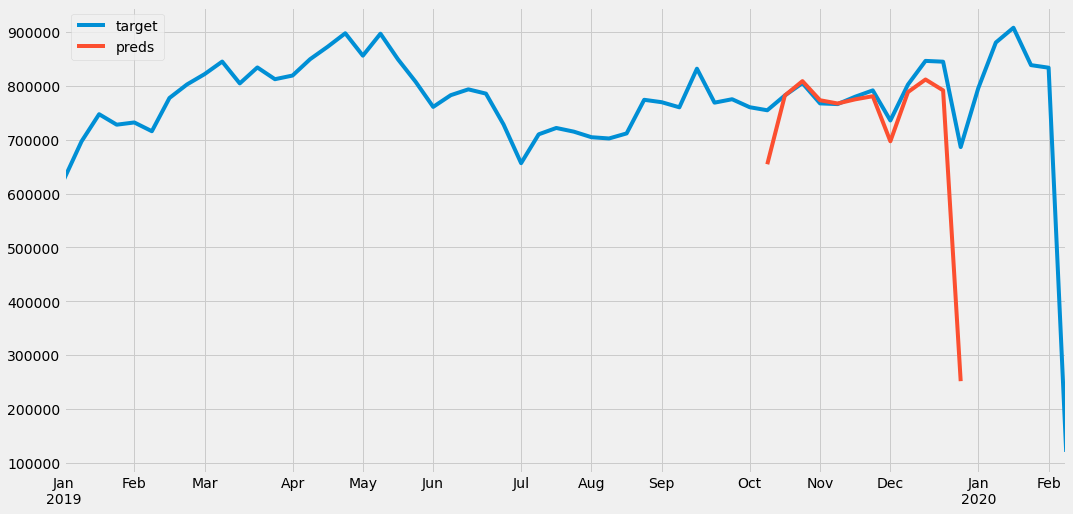

In [41]:
ax = total_visits_df.resample('1W').sum().plot(figsize=(16, 8))
total_preds_visits_df.resample('1W').sum().plot(ax=ax)
ax.legend(labels=('target', 'preds'))

### Checking Grocery Stores' Patterns

In [25]:
groc_df = get_df_timeseries(agg_df, 'Grocery Stores')
groc_df

,visits
2018-12-31 00:00:00,9
2018-12-31 01:00:00,8
2018-12-31 02:00:00,13
2018-12-31 03:00:00,16
2018-12-31 04:00:00,34
...,...
2020-02-03 19:00:00,208
2020-02-03 20:00:00,105
2020-02-03 21:00:00,77
2020-02-03 22:00:00,53


In [26]:
preds_groc_df = get_preds_timeseries(preds_agg_df, 'Grocery Stores', valid_dates)
preds_groc_df

,visits
2019-10-08 00:00:00,11.610887
2019-10-08 01:00:00,9.55035
2019-10-08 02:00:00,7.418726
2019-10-08 03:00:00,11.580074
2019-10-08 04:00:00,20.656917
...,...
2019-12-25 14:00:00,55.335521
2019-12-25 15:00:00,52.624588
2019-12-25 16:00:00,47.291504
2019-12-25 17:00:00,42.73728


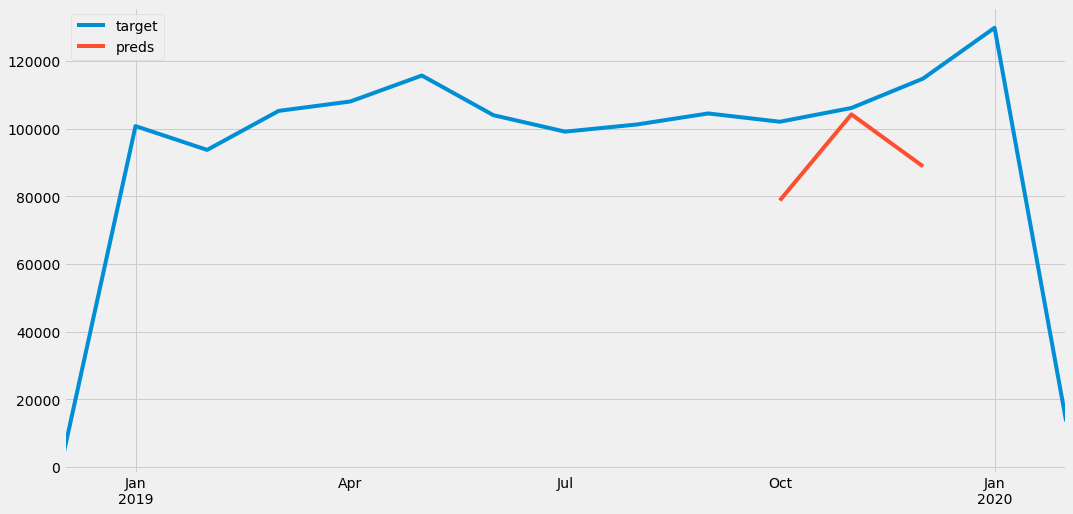

In [27]:
plt.style.use('fivethirtyeight')
ax = groc_df.resample('1M').sum().plot(figsize=(16, 8))
preds_groc_df.resample('1M').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

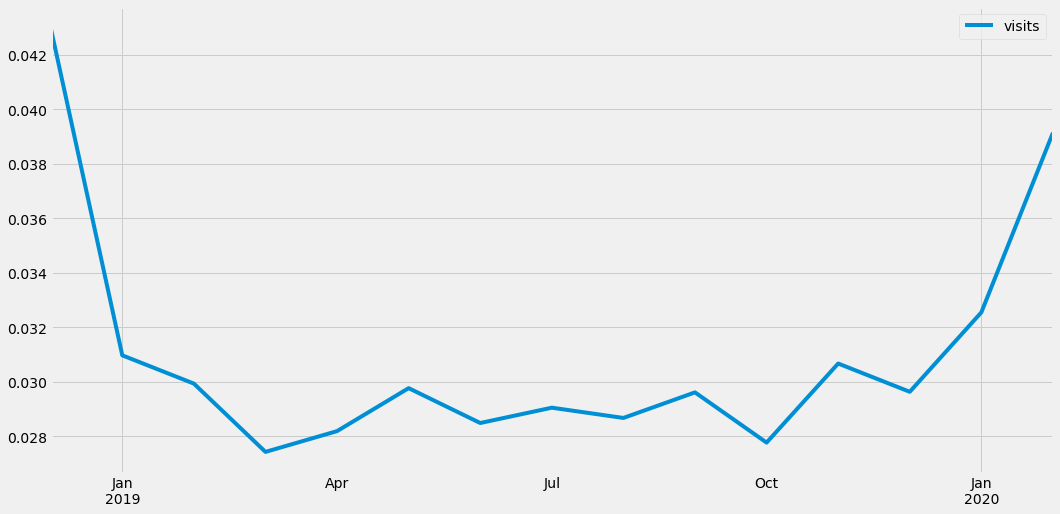

In [28]:
pd.DataFrame(groc_df['visits'] / total_visits_df['visits']).resample('1M').mean().plot(figsize=(16, 8))

### Checking Gas Stations' Patterns

In [29]:
gas_df = get_df_timeseries(agg_df, 'Gasoline Stations')
gas_df

,visits
2018-12-31 00:00:00,27
2018-12-31 01:00:00,27
2018-12-31 02:00:00,19
2018-12-31 03:00:00,39
2018-12-31 04:00:00,82
...,...
2020-02-03 19:00:00,184
2020-02-03 20:00:00,173
2020-02-03 21:00:00,67
2020-02-03 22:00:00,67


In [30]:
preds_gas_df = get_preds_timeseries(preds_agg_df, 'Gasoline Stations', valid_dates)
preds_gas_df

,visits
2019-10-08 00:00:00,37.350635
2019-10-08 01:00:00,33.406185
2019-10-08 02:00:00,28.892509
2019-10-08 03:00:00,43.770403
2019-10-08 04:00:00,77.121045
...,...
2019-12-25 14:00:00,144.1683
2019-12-25 15:00:00,178.312933
2019-12-25 16:00:00,156.46635
2019-12-25 17:00:00,204.51182


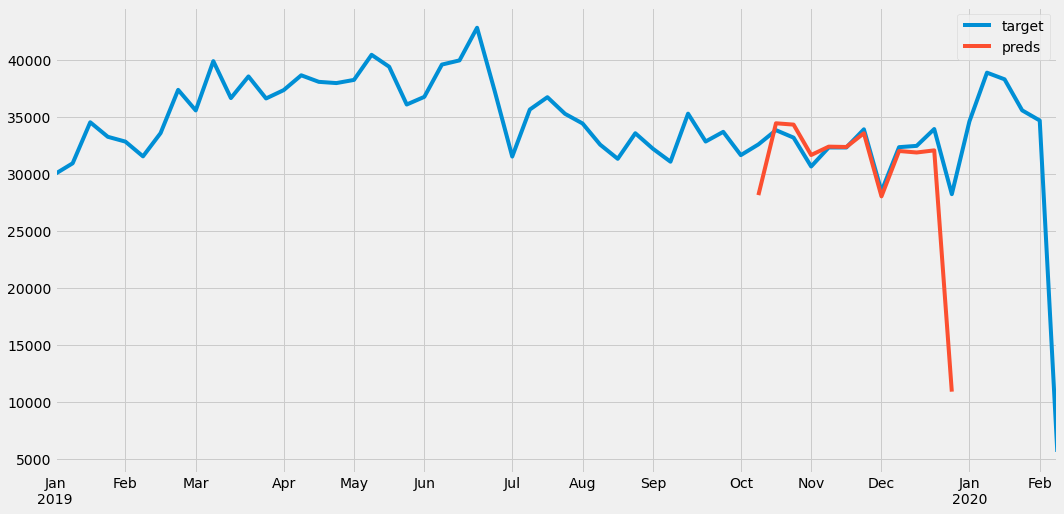

In [31]:
ax = gas_df.resample('1W').sum().plot(figsize=(16, 8))
preds_gas_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

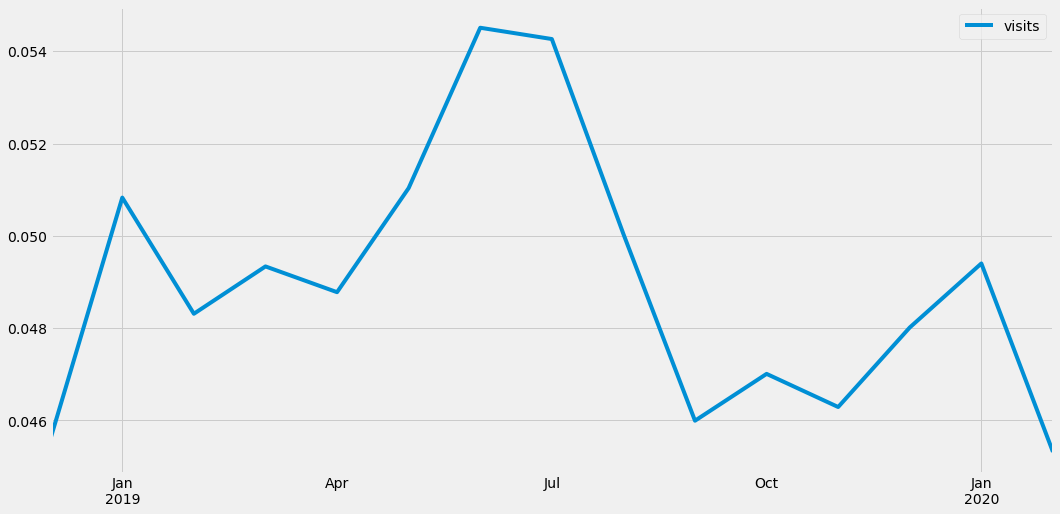

In [32]:
pd.DataFrame(gas_df['visits'] / total_visits_df['visits']).resample('1M').mean().plot(figsize=(16, 8))

### Checking Schools' Visit Patterns

In [33]:
sch_df = get_df_timeseries(agg_df, 'Elementary and Secondary Schools')
sch_df

,visits
2018-12-31 00:00:00,9
2018-12-31 01:00:00,11
2018-12-31 02:00:00,11
2018-12-31 03:00:00,4
2018-12-31 04:00:00,9
...,...
2020-02-03 19:00:00,154
2020-02-03 20:00:00,47
2020-02-03 21:00:00,35
2020-02-03 22:00:00,24


In [34]:
preds_sch_df = get_preds_timeseries(preds_agg_df, 'Elementary and Secondary Schools', valid_dates)
preds_sch_df

,visits
2019-10-08 00:00:00,18.483921
2019-10-08 01:00:00,-3.840894
2019-10-08 02:00:00,73.869459
2019-10-08 03:00:00,-12.950974
2019-10-08 04:00:00,5.218971
...,...
2019-12-25 14:00:00,28.720174
2019-12-25 15:00:00,7.534072
2019-12-25 16:00:00,3.951216
2019-12-25 17:00:00,17.684132


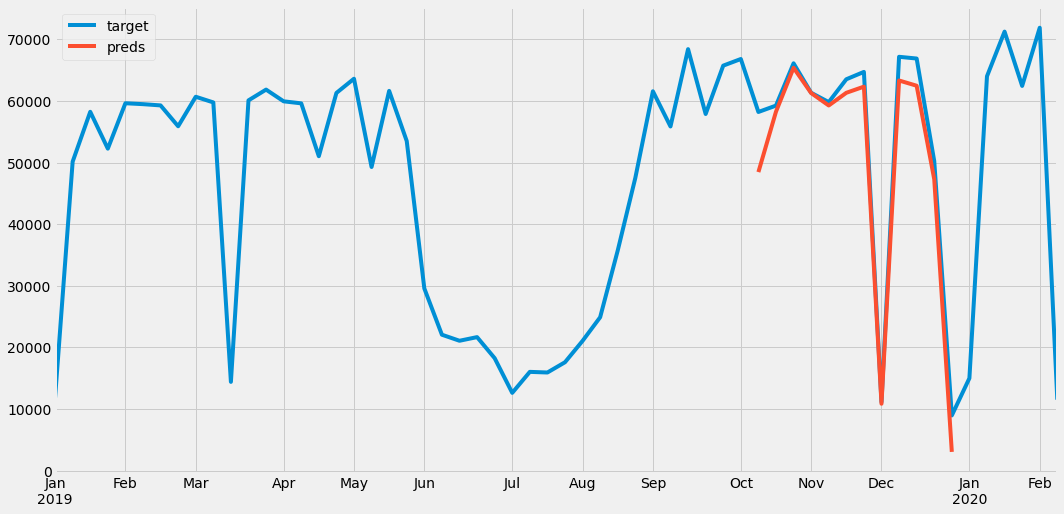

In [35]:
ax = sch_df.resample('1W').sum().plot(figsize=(16, 8))
preds_sch_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

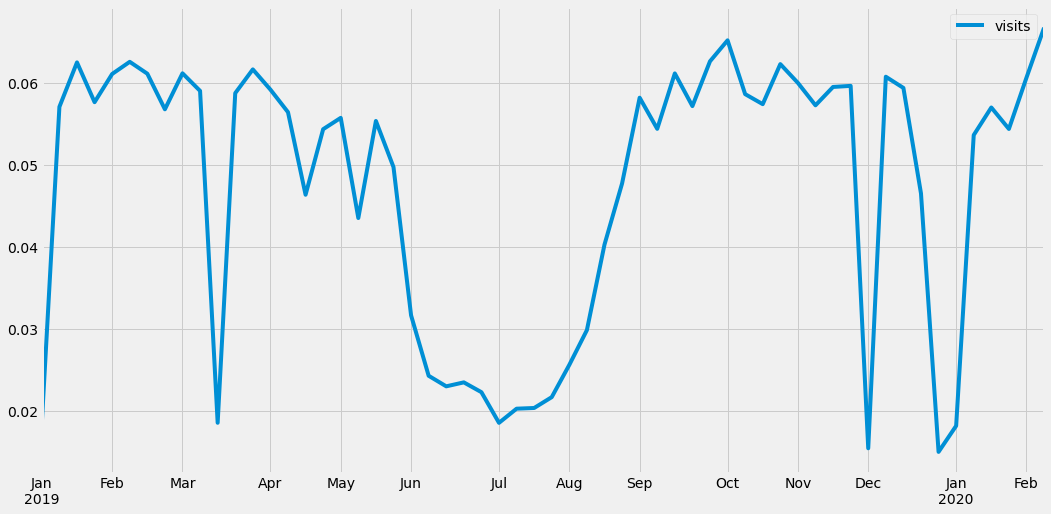

In [36]:
pd.DataFrame(sch_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))

### Checking Restaurants' Visit Patterns

In [37]:
rest_df = get_df_timeseries(agg_df, 'Restaurants and Other Eating Places')
rest_df

,visits
2018-12-31 00:00:00,62
2018-12-31 01:00:00,68
2018-12-31 02:00:00,56
2018-12-31 03:00:00,58
2018-12-31 04:00:00,52
...,...
2020-02-03 19:00:00,228
2020-02-03 20:00:00,162
2020-02-03 21:00:00,136
2020-02-03 22:00:00,84


In [38]:
preds_rest_df = get_preds_timeseries(preds_agg_df, 'Restaurants and Other Eating Places', valid_dates)
preds_rest_df

,visits
2019-10-08 00:00:00,67.963427
2019-10-08 01:00:00,40.201344
2019-10-08 02:00:00,68.233135
2019-10-08 03:00:00,50.90447
2019-10-08 04:00:00,67.504657
...,...
2019-12-25 14:00:00,154.658505
2019-12-25 15:00:00,134.722105
2019-12-25 16:00:00,124.911047
2019-12-25 17:00:00,99.874437


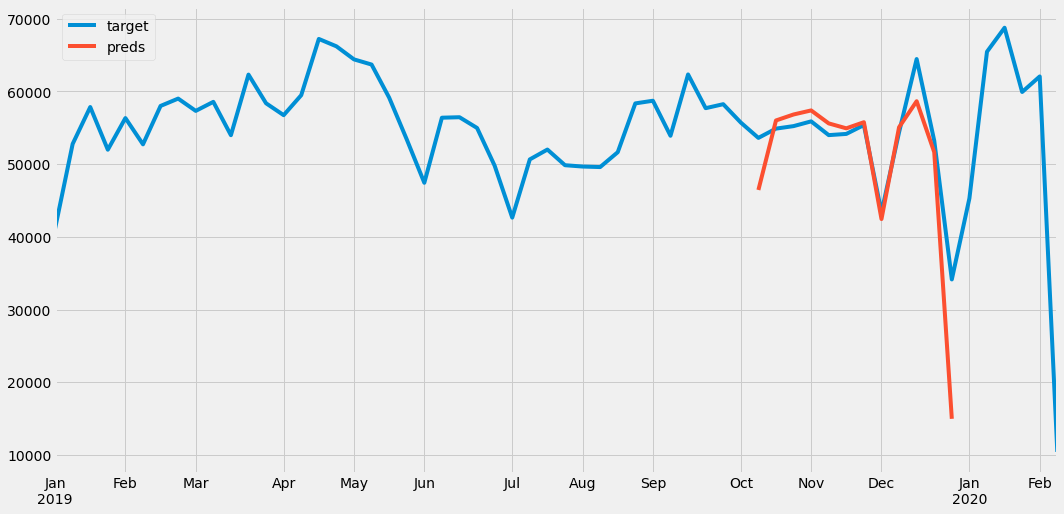

In [39]:
ax = rest_df.resample('1W').sum().plot(figsize=(16, 8))
preds_rest_df.resample('1W').sum().plot(figsize=(16, 8), ax=ax)
ax.legend(labels=('target', 'preds'))

<AxesSubplot:>

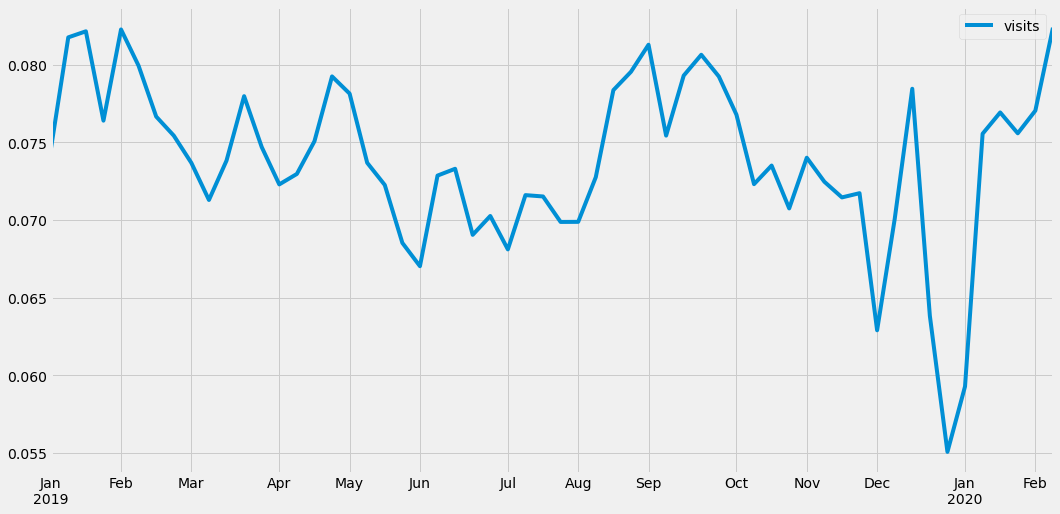

In [40]:
pd.DataFrame(rest_df['visits'] / total_visits_df['visits']).resample('1W').mean().plot(figsize=(16, 8))